In [8]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# simple autoencoder pca equivalent
encoder = tf.keras.Sequential([tf.keras.layers.Dense(2)])
decoder = tf.keras.Sequential([tf.keras.layers.Dense(3)])
autoencoder = tf.keras.Sequential([encoder, decoder])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.5)
autoencoder.compile(loss='mse', optimizer=optimizer)

I0000 00:00:1727779190.983418    4268 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727779191.381850    4268 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727779191.381929    4268 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727779191.391471    4268 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1727779191.391563    4268 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [5]:
tf.random.set_seed(42)

# stacked autoencoder
stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(30, activation='relu')
])
stacked_decoder = tf.keras.Sequential([
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(28 * 28),
    tf.keras.layers.Reshape([28, 28])
])
stacked_autoencoder = tf.keras.Sequential([stacked_encoder, stacked_decoder])
stacked_autoencoder.compile(loss='mse', optimizer='nadam')

In [6]:
# fashion mnist data
fm_dataset = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fm_dataset
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [7]:
history = stacked_autoencoder.fit(X_train, X_train, epochs=20, validation_data=(X_valid, X_valid))

Epoch 1/20


I0000 00:00:1727779195.628992   58179 service.cc:146] XLA service 0x7fe718009840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727779195.629446   58179 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-10-01 12:39:55.786095: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-01 12:39:56.140100: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-01 12:39:59.774124: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_553', 72 bytes spill stores, 72 bytes spill loads

2024-10-01 12:40:01.170915: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in functio

  44/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 8726.0547    

I0000 00:00:1727779205.490979   58179 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1712/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2231.9148

2024-10-01 12:40:16.566644: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_553', 84 bytes spill stores, 84 bytes spill loads

2024-10-01 12:40:17.191643: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_553', 4 bytes spill stores, 4 bytes spill loads

2024-10-01 12:40:18.199246: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_553', 324 bytes spill stores, 324 bytes spill loads

2024-10-01 12:40:19.354354: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_610', 12 bytes spill stores, 12 bytes spill loads

2024-10-01 12:40:19.691485: I external/local_xla/xla/stream_exec

1719/1719 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 2228.4072 - val_loss: 1111.5829
Epoch 2/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 1073.6382 - val_loss: 1026.2914
Epoch 3/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 1007.8788 - val_loss: 990.9708
Epoch 4/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - loss: 976.9650 - val_loss: 971.7231
Epoch 5/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 957.6903 - val_loss: 958.1497
Epoch 6/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 941.9590 - val_loss: 947.5019
Epoch 7/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 929.5409 - val_loss: 934.4786
Epoch 8/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 919.5294 - val_loss: 932.4716
Epoch 9/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 911.8381 - val_loss: 926.8690
Epoch 10/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 904.9061 - val_loss: 920.5669
Epoch 11/20
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 898.4750 - val_l

In [9]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1+image_index)
        plt.imshow(images[image_index], cmap='binary')
        plt.axis('off')
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap='binary')
        plt.axis('off')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


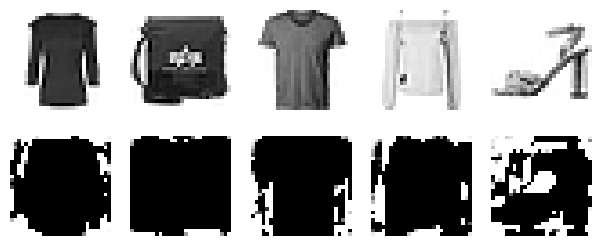

In [10]:
plot_reconstructions(stacked_autoencoder)
plt.show()